In [1]:
import psycopg2
import pandas as pd
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Display full content in each cell

In [2]:

host = "localhost"
port = "5432"

# PostgreSQL credentials
user = "tanmay"
password = "pass_postgre1"
database = "mimic4_clinical_demo"

# Connect to PostgreSQL
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
    )
    print("PSQL Connection successful!")
except Exception as e:
    print(f"Error connecting to database: {e}")

PSQL Connection successful!


In [ ]:
# Execute Query
def exec_query(query):
    try:
        # Establish the connection
        conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
        )
        cursor = conn.cursor()
        # Execute the query
        cursor.execute(query)
        # Fetch column names from the cursor
        colnames = [desc[0] for desc in cursor.description]
        # Fetch all rows of the query
        results = cursor.fetchall()
        # Create a DataFrame with column names
        df = pd.DataFrame(results, columns=colnames)
        # Close the cursor and connection
        cursor.close()
        conn.close()
        # Return the DataFrame
        return df

    except Exception as e:
        print(f"Error executing query: {e}")
        # Roll back the transaction in case of error
        conn.rollback()
        cursor.close()
        conn.close()
        return None

# 1: Data Extraction & Preprocessing for Staffing Needs

In [4]:
# Extract admissions and discharge time
query = """
SELECT hadm_id, admittime, dischtime
FROM admissions
WHERE admittime IS NOT NULL AND dischtime IS NOT NULL;
"""

staffing_df = exec_query(query)

# Convert timestamps to datetime
staffing_df["admittime"] = pd.to_datetime(staffing_df["admittime"])
staffing_df["dischtime"] = pd.to_datetime(staffing_df["dischtime"])

# Extract Shift Information
def get_shift(hour):
    if 6 <= hour < 14:
        return "Morning"
    elif 14 <= hour < 22:
        return "Afternoon"
    else:
        return "Night"

staffing_df["shift"] = staffing_df["admittime"].dt.hour.apply(get_shift)

# Aggregate admissions per shift
staffing_shift_df = staffing_df.groupby(["admittime", "shift"]).size().reset_index(name="admission_count")

display(staffing_shift_df)


,admittime,shift,admission_count
0,2110-04-11 15:08:00,Afternoon,1
1,2110-11-30 06:31:00,Morning,1
2,2111-01-15 14:55:00,Afternoon,1
3,2111-11-13 23:39:00,Night,1
4,2112-09-17 19:13:00,Afternoon,1
...,...,...,...
269,2201-02-12 16:58:00,Afternoon,1
270,2201-03-23 19:15:00,Afternoon,1
271,2201-07-07 18:15:00,Afternoon,1
272,2201-10-30 12:05:00,Morning,1


#  2: Feature Engineering for Staffing Needs Forecasting

In [5]:
# Convert admittime to date for aggregation
staffing_shift_df["date"] = staffing_shift_df["admittime"].dt.date
staffing_shift_df["day_of_week"] = staffing_shift_df["admittime"].dt.dayofweek  # 0=Monday, 6=Sunday
staffing_shift_df["month"] = staffing_shift_df["admittime"].dt.month

# Aggregate admissions per shift on a daily level
daily_staffing_df = staffing_shift_df.groupby(["date", "shift"]).agg({
    "admission_count": "sum",
    "day_of_week": "first",
    "month": "first"
}).reset_index()

# Convert date to datetime for modeling
daily_staffing_df["date"] = pd.to_datetime(daily_staffing_df["date"])

# Encode Shift as Numerical Values
shift_mapping = {"Morning": 0, "Afternoon": 1, "Night": 2}
daily_staffing_df["shift_encoded"] = daily_staffing_df["shift"].map(shift_mapping)

# Display processed features
display(daily_staffing_df.head())


,date,shift,admission_count,day_of_week,month,shift_encoded
0,2110-04-11,Afternoon,1,4,4,1
1,2110-11-30,Morning,1,6,11,0
2,2111-01-15,Afternoon,1,3,1,1
3,2111-11-13,Night,1,4,11,2
4,2112-09-17,Afternoon,1,5,9,1


# 3: Train the Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Sort data by date for time-series forecasting
daily_staffing_df = daily_staffing_df.sort_values("date")

# Features & Target
X = daily_staffing_df[["day_of_week", "month", "shift_encoded"]]
y = daily_staffing_df["admission_count"]

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize Model (Choose One)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train Model
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluation Metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))


In [9]:
# Print Results
print(f"Random Forest MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")

Random Forest MAE: 0.0182, RMSE: 0.1348
XGBoost MAE: 0.0182, RMSE: 0.1348


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate future dates for the next 30 days
future_dates = pd.date_range(start=daily_staffing_df["date"].max(), periods=31, freq="D")[1:]

# Create a DataFrame for prediction
future_df = pd.DataFrame(future_dates, columns=["date"])

# Extract day_of_week and month features
future_df["day_of_week"] = future_df["date"].dt.dayofweek
future_df["month"] = future_df["date"].dt.month

# Assign shift categories (Morning, Afternoon, Night)
shifts = ["Morning", "Afternoon", "Night"]
future_df = future_df.loc[future_df.index.repeat(3)]  # Repeat each day for all shifts
future_df["shift"] = shifts * (len(future_df) // 3)

# Encode shift column
shift_encoding = {"Morning": 0, "Afternoon": 1, "Night": 2}
future_df["shift_encoded"] = future_df["shift"].map(shift_encoding)

# Predict future admission counts
X_future = future_df[["day_of_week", "month", "shift_encoded"]]
future_df["predicted_admission_count"] = xgb_model.predict(X_future)



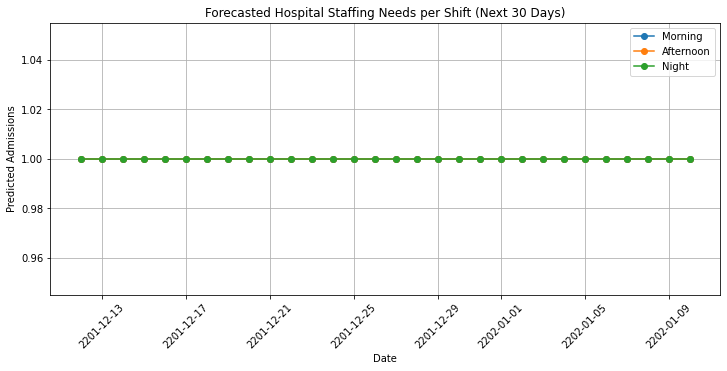

In [11]:
# Plot Future Forecast
plt.figure(figsize=(12, 5))
for shift in shifts:
    shift_data = future_df[future_df["shift"] == shift]
    plt.plot(shift_data["date"], shift_data["predicted_admission_count"], marker="o", label=shift)

plt.xlabel("Date")
plt.ylabel("Predicted Admissions")
plt.title("Forecasted Hospital Staffing Needs per Shift (Next 30 Days)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Based on the result - Checking data distribution

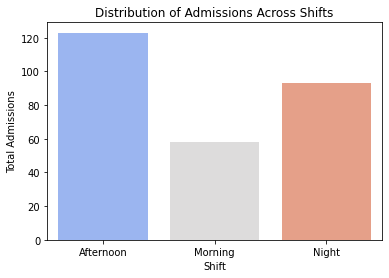

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count admissions per shift
shift_counts = daily_staffing_df.groupby("shift")["admission_count"].sum().reset_index()

# Plot shift distribution
plt.figure(figsize=(6, 4))
sns.barplot(x="shift", y="admission_count", data=shift_counts, palette="coolwarm")
plt.xlabel("Shift")
plt.ylabel("Total Admissions")
plt.title("Distribution of Admissions Across Shifts")
plt.show()

### Perform Oversampling
We will duplicate Morning (60 → 120) and Night (90 → 120) to match Afternoon.

In [14]:
from sklearn.utils import resample

# Separate classes
morning = daily_staffing_df[daily_staffing_df["shift"] == "Morning"]
afternoon = daily_staffing_df[daily_staffing_df["shift"] == "Afternoon"]
night = daily_staffing_df[daily_staffing_df["shift"] == "Night"]

# Oversample morning and night shifts to match Afternoon count (120)
morning_upsampled = resample(morning, replace=True, n_samples=120, random_state=42)
night_upsampled = resample(night, replace=True, n_samples=120, random_state=42)

# Combine all datasets
balanced_df = pd.concat([morning_upsampled, afternoon, night_upsampled])

# Check final shift distribution
print("Balanced Dataset Shift Counts:\n", balanced_df["shift"].value_counts())


Balanced Dataset Shift Counts:
 Afternoon    123
Morning      120
Night        120
Name: shift, dtype: int64


### Retrain & Forecast Again
Since we oversampled, we need to retrain Random Forest & XGBoost with the balanced dataset.

In [15]:
# Encode shift column
shift_encoding = {"Morning": 0, "Afternoon": 1, "Night": 2}
balanced_df["shift_encoded"] = balanced_df["shift"].map(shift_encoding)

X_balanced = balanced_df[["day_of_week", "month", "shift_encoded"]]
y_balanced = balanced_df["admission_count"]

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_balanced, y_balanced)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_balanced, y_balanced)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Forecast Again & Evaluate

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions
rf_pred = rf_model.predict(X_balanced)
xgb_pred = xgb_model.predict(X_balanced)

# Evaluate models
rf_mae = mean_absolute_error(y_balanced, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_balanced, rf_pred))

xgb_mae = mean_absolute_error(y_balanced, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_balanced, xgb_pred))

print(f"Random Forest MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")


Random Forest MAE: 0.0078, RMSE: 0.0608
XGBoost MAE: 0.0074, RMSE: 0.0606


### Visualize Shift-wise Predictions
Plot the forecasted hospital staffing needs per shift over the next 30 days ugin XGB Model.

In [ ]:
from datetime import datetime, timedelta

# Create future date range for next 30 days
future_dates = [datetime.today() + timedelta(days=i) for i in range(30)]

# Generate shift assignments for future dates (cycling through Morning, Afternoon, Night)
future_shifts = ["Morning", "Afternoon", "Night"] * 10

# Create dataframe
future_df = pd.DataFrame({"date": future_dates, "shift": future_shifts})

# Encode categorical features
shift_encoding = {"Morning": 0, "Afternoon": 1, "Night": 2}
future_df["shift_encoded"] = future_df["shift"].map(shift_encoding)

# Extract **day_of_week** and **month** for consistency with training data
future_df["day_of_week"] = [date.weekday() for date in future_df["date"]]
future_df["month"] = [date.month for date in future_df["date"]]

# Prepare feature set for prediction (MUST match training features)
X_future = future_df[rf_model.feature_names_in_]  # Use exact order from training


# Predict using trained xgb model
future_df["xgb_predicted_admission_count"] = xgb_model.predict(X_future)


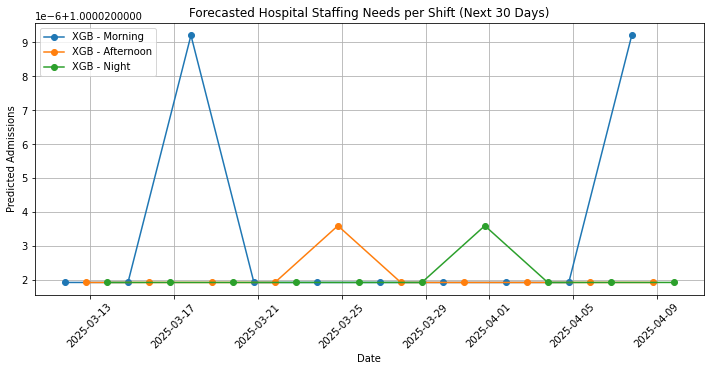

In [25]:
import matplotlib.pyplot as plt

# Plot Future Forecast
plt.figure(figsize=(12, 5))
shifts = ["Morning", "Afternoon", "Night"]

for shift in shifts:
    shift_data = future_df[future_df["shift"] == shift]
    plt.plot(shift_data["date"], shift_data["xgb_predicted_admission_count"], marker="o", label=f"XGB - {shift}")

plt.xlabel("Date")
plt.ylabel("Predicted Admissions")
plt.title("Forecasted Hospital Staffing Needs per Shift (Next 30 Days)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
